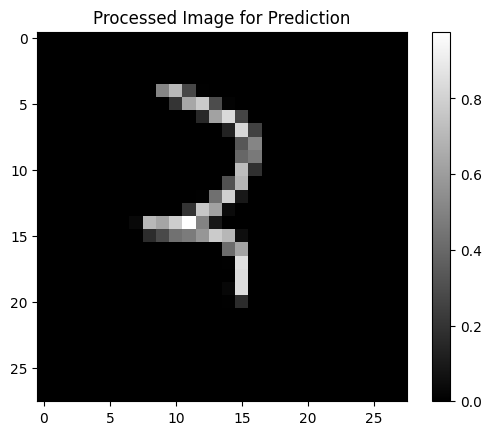

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
Raw Prediction: [[9.5507603e-05 2.5638375e-02 4.5331410e-01 1.0253041e-01 7.1023847e-03
  5.3097366e-04 4.7826699e-05 4.0545294e-01 3.9869309e-03 1.3006463e-03]]


SystemExit: 0

C:\ProgramData\anaconda3\envs\mnist_env\lib\site-packages\IPython\core\interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [1]:
import sys
import numpy as np
import cv2
import tensorflow as tf
from PyQt5.QtWidgets import QApplication, QWidget, QPushButton, QLabel
from PyQt5.QtGui import QPainter, QPen, QImage
from PyQt5.QtCore import Qt, QPoint
import matplotlib.pyplot as plt


class DrawApp(QWidget):
    def __init__(self):
        super().__init__()

        self.setWindowTitle("Draw a Number")
        self.setGeometry(100, 100, 400, 400)
        self.setStyleSheet("background-color: white;")

        self.image = QImage(400, 400, QImage.Format_RGB32)
        self.image.fill(Qt.white)

        self.clear_button = QPushButton("Clear", self)
        self.clear_button.setGeometry(150, 350, 100, 40)
        self.clear_button.clicked.connect(self.clear_canvas)

        self.predict_button = QPushButton("Predict", self)
        self.predict_button.setGeometry(260, 350, 100, 40)
        self.predict_button.clicked.connect(self.predict_digit)

        self.result_label = QLabel("Prediction: ", self)
        self.result_label.setGeometry(20, 360, 120, 30)

        self.model = tf.keras.models.load_model("model.h5", compile=False)
        self.model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

        self.drawing = False
        self.last_point = QPoint()

    def mousePressEvent(self, event):
        if event.button() == Qt.LeftButton:
            self.drawing = True
            self.last_point = event.pos()

    def mouseMoveEvent(self, event):
        if self.drawing and event.buttons() & Qt.LeftButton:
            painter = QPainter(self.image)
            pen = QPen(Qt.black, 12, Qt.SolidLine, Qt.RoundCap, Qt.RoundJoin)
            painter.setPen(pen)
            painter.drawLine(self.last_point, event.pos())
            self.last_point = event.pos()
            self.update()

    def mouseReleaseEvent(self, event):
        if event.button() == Qt.LeftButton:
            self.drawing = False

    def paintEvent(self, event):
        canvas = QPainter(self)
        canvas.drawImage(self.rect(), self.image, self.image.rect())

    def clear_canvas(self):
        self.image.fill(Qt.white)
        self.update()

   

    def preprocess_image(self):
        img = self.image.convertToFormat(QImage.Format_Grayscale8)
        buffer = img.bits()
        buffer.setsize(400 * 400)
        img_array = np.frombuffer(buffer, dtype=np.uint8).reshape(400, 400)
        img_array = 255 - img_array
    
        # 1. Bounding Box and Centering:
        non_zero_pixels = np.argwhere(img_array != 255)
        if len(non_zero_pixels) > 0:
            (min_y, min_x) = non_zero_pixels.min(axis=0)
            (max_y, max_x) = non_zero_pixels.max(axis=0)
            cropped_digit = img_array[min_y:max_y + 1, min_x:max_x + 1]
            
            #create a square image to paste the cropped digit in.
            size = max(cropped_digit.shape)
            padded_digit = np.ones((size,size), dtype = np.uint8) * 255
            
            offset_y = (size - cropped_digit.shape[0]) // 2
            offset_x = (size - cropped_digit.shape[1]) // 2
            
            padded_digit[offset_y:offset_y+cropped_digit.shape[0], offset_x:offset_x+cropped_digit.shape[1]] = cropped_digit
    
            img_resized = cv2.resize(padded_digit, (28, 28), interpolation=cv2.INTER_AREA)
    
        else:
            #if the canvas is empty return a blank image.
            img_resized = np.ones((28,28), dtype = np.uint8) * 255
    
        img_resized = img_resized.astype("float32") / 255.0
        kernel = np.ones((3, 3), np.uint8)
 #       img_resized = cv2.dilate(img_resized, kernel, iterations=1)
        img_resized = np.expand_dims(img_resized, axis=(0, -1))
        
        plt.imshow(img_resized[0, :, :, 0], cmap="gray")
        plt.title("Processed Image for Prediction")
        plt.colorbar()
        plt.show()
    
        return img_resized


    def predict_digit(self):
        """Handle prediction and display result."""
        processed_img = self.preprocess_image()
        prediction = self.model.predict(processed_img)
        print("Raw Prediction:", prediction)  # Debugging: print raw prediction
        digit = np.argmax(prediction)
        self.result_label.setText(f"Prediction: {digit}")


    # Assuming `image` is the numpy array captured from the frontend
    def show_processed_image(image):
        if image is not None:
            plt.imshow(image, cmap='gray')
            plt.title("Captured Input from Canvas")
            plt.show()
        else:
            print("No image received from the frontend!")

if __name__ == "__main__":
    app = QApplication(sys.argv)
    window = DrawApp()
    window.show()
    sys.exit(app.exec_())
